In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import utils

In [67]:
# Import training/test files in Pandas
# CSV_COLUMN_NAMES = [
#     'path','left_eye_x','right_eye_x','nose_x','left_mouth_x','right_mouth_x','left_eye_y','right_eye_y',
#     'nose_y','left_mouth_y','right_mouth_y','gender','smile','glasses','head_pose']
# train_data = pd.read_csv('training.txt', sep=' ',names=CSV_COLUMN_NAMES, header=None, skipinitialspace=True, nrows=10000)
# test_data = pd.read_csv('testing.txt', sep=' ',names=CSV_COLUMN_NAMES, header=None, skipinitialspace=True, nrows=2995)
# # Simple hack to replace \ with /
# train_data.iloc[:, 0] = train_data.iloc[:, 0].apply(lambda s: s.replace('\\', '/')) # Needed for filename convention
# test_data.iloc[:, 0] = test_data.iloc[:, 0].apply(lambda s: s.replace('\\', '/')) # Needed for filename convention

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('new_test.csv')
train_data.head()

,left_eye_x,right_eye_x,nose_x,left_mouth_x,right_mouth_x,left_eye_y,right_eye_y,nose_y,left_mouth_y,right_mouth_y,gender,smile,glasses,head_pose,path
0,0.429,0.591,0.505,0.425,0.563,0.435,0.453,0.575,0.635,0.651,1.0,2.0,2.0,3.0,lfw_5590/Aaron_Eckhart_0001.jpg
1,0.405,0.587,0.501,0.375,0.559,0.449,0.471,0.551,0.643,0.659,1.0,1.0,2.0,3.0,lfw_5590/Aaron_Guiel_0001.jpg
2,0.431,0.591,0.521,0.437,0.591,0.457,0.457,0.563,0.617,0.615,1.0,1.0,2.0,3.0,lfw_5590/Aaron_Peirsol_0001.jpg
3,0.411,0.585,0.505,0.483,0.589,0.471,0.419,0.551,0.659,0.627,1.0,2.0,2.0,3.0,lfw_5590/Aaron_Pena_0001.jpg
4,0.409,0.579,0.523,0.401,0.573,0.453,0.451,0.555,0.625,0.623,1.0,1.0,2.0,3.0,lfw_5590/Aaron_Sorkin_0001.jpg


In [3]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def _parse_function(filename):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3) # Channels needed because some test images are b/w
    image_resized = tf.image.resize(image_decoded, [40, 40])
#     image_shape = tf.cast(tf.shape(image_decoded), tf.float32)
    # 將位置轉換成比例
#     label = tf.concat([label[0:5] / image_shape[0], label[5:10] / image_shape[1], label[10:]], axis=0)
    return image_resized

In [132]:
train_data_x = np.ndarray((len(train_data), 40, 40, 3))
train_data_y = np.ndarray((len(train_data), 14))
test_data_x = np.ndarray((len(test_data), 40, 40, 3))
test_data_y = np.ndarray((len(test_data), 14))

In [5]:
for i, row in enumerate(train_data.values):
    print(row)
    break

[0.4289999902248383 0.5910000205039978 0.5049999952316284
 0.42500001192092896 0.5630000233650208 0.4350000023841858
 0.453000009059906 0.574999988079071 0.6349999904632568 0.6510000228881836
 1.0 2.0 2.0 3.0 'lfw_5590/Aaron_Eckhart_0001.jpg']


In [6]:
# # 讀取路徑後，將讀取的圖片調整大小，test_data_x
for i, row in enumerate(test_data.values):
    image = _parse_function(row[0])
    test_data_x[i] = image
    if i%2000 == 0: print('Processed {} of {}'.format(i, len(test_data)))

Processed 0 of 2995
Processed 2000 of 2995


In [133]:
# 讀取路徑後，將讀取的圖片調整大小，並存入train_data_x, train_data_y
for i, row in enumerate(train_data.values):
    image = _parse_function(row[14])

    train_data_x[i] = image
    train_data_y[i] = row[:14]
    if i%2000 == 0: print('Processed {} of {}'.format(i, len(train_data)))

Processed 0 of 10000
Processed 2000 of 10000
Processed 4000 of 10000
Processed 6000 of 10000
Processed 8000 of 10000


In [95]:
for i, row in enumerate(test_data.values):
    image = _parse_function(row[14])
    test_data_x[i] = image
    test_data_y[i] = row[:14]
    if i%2000 == 0: print('Processed {} of {}'.format(i, len(test_data)))

Processed 0 of 2995
Processed 2000 of 2995


# ONLY Dense

In [46]:
inputs = tf.keras.Input(shape=(40,40,3))
flat = tf.keras.layers.Flatten()(inputs)
dense1 = tf.keras.layers.Dense(units=1024, activation="relu")(flat)
dense1 = tf.keras.layers.Dropout(0.5)(dense1)
dense2 = tf.keras.layers.Dense(units=1024, activation="relu")(dense1)
dense2 = tf.keras.layers.Dropout(0.5)(dense2)
dense3 = tf.keras.layers.Dense(units=256, activation="relu")(dense2)
dense3 = tf.keras.layers.Dropout(0.5)(dense3)
dense4 = tf.keras.layers.Dense(units=128, activation="relu")(dense3)
dense4 = tf.keras.layers.Dense(units=64, activation="relu")(dense4)

# predictions_gender = tf.keras.layers.Dense(units=1, activation='sigmoid')(dense4)
predictions_smile = tf.keras.layers.Dense(units=1, activation='sigmoid')(dense4)

dense_left = tf.keras.layers.Dense(units=64, activation="relu")(dense4)
predictions_right_mouth = tf.keras.layers.Dense(units=2)(dense_left)

dense_right = tf.keras.layers.Dense(units=64, activation="relu")(dense4)
predictions_left_mouth = tf.keras.layers.Dense(units=2)(dense_right)

model = tf.keras.Model(inputs=inputs, outputs=[predictions_smile,predictions_left_mouth, predictions_right_mouth])
model.compile(optimizer=tf.optimizers.Adam(lr = 0.0001),
              loss=[tf.keras.losses.BinaryCrossentropy(),tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanSquaredError()], metrics = ['mse', 'accuracy'])

In [31]:

# inputs = tf.keras.Input(shape=(40,40,3))

# # First convolutive layer
# conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)(inputs)
# pool1 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)(conv1)

# # Second convolutive layer
# conv2 = tf.keras.layers.Conv2D(filters=48, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)(pool1)
# pool2 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)(conv2)

# # Third convolutive layer
# conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)(pool2)
# pool3 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)(conv3)

# # Fourth convolutive layer
# conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=[2, 2], padding="same", activation=tf.nn.relu)(pool3)

# # Dense Layer
# flat = tf.reshape(conv4, [-1, 5 * 5 * 64])
# predictions_nose = tf.keras.layers.Dense(units=2)(flat)
# predictions_pose = tf.keras.layers.Dense(units=5,activation=tf.nn.softmax)(flat)


# model = tf.keras.Model(inputs=inputs, outputs=[predictions_nose, predictions_pose])
# model.compile(optimizer=tf.optimizers.Adam(),
#               loss=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.categorical_crossentropy], metrics = ['mse', 'accuracy'])

In [47]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 40, 40, 3)]  0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 4800)         0           input_5[0][0]                    
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 1024)         4916224     flatten_2[0][0]                  
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 1024)         0           dense_24[0][0]                   
____________________________________________________________________________________________

In [48]:
from tensorflow.keras import utils

In [135]:
nose_pos = utils.to_categorical(train_data_y[:,-1]-1)

In [136]:
nose_pos

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [137]:
train_data_y[:,5][0]

0.4350000023841858

# 前處理資料

In [138]:
gender = train_data_y[:,11] -1
smile = train_data_y[:,12] -1
left_mouth = train_data_y[:,3:9:5]
right_mouth = train_data_y[:,4:10:5]

In [139]:
right_mouth

array([[0.56300002, 0.65100002],
       [0.55900002, 0.65899998],
       [0.59100002, 0.61500001],
       ...,
       [0.43055555, 0.67500001],
       [0.43055555, 0.58125001],
       [0.41666666, 0.61250001]])

In [140]:
len(train_data_y)

10000

In [141]:
right_mouth.shape

(10000, 2)

In [52]:
gender.shape

(10000,)

In [53]:
smile.shape

(10000,)

In [54]:
nose_pos.shape

(10000, 5)

In [55]:
left_mouth.shape

(10000, 2)

In [56]:
right_mouth.shape

(10000, 2)

In [57]:
EPOCHS = 10

In [81]:
model.fit(train_data_x,[smile, left_mouth,right_mouth],epochs=EPOCHS, batch_size=128)

Train on 10000 samples
Epoch 1/50
10000/10000 [==============================] - 8s 803us/sample - loss: 0.4218 - dense_29_loss: 0.4140 - dense_33_loss: 0.0031 - dense_31_loss: 0.0044 - dense_29_mse: 0.1232 - dense_29_accuracy: 0.8592 - dense_33_mse: 0.0031 - dense_33_accuracy: 1.0000 - dense_31_mse: 0.0043 - dense_31_accuracy: 0.7841
Epoch 2/50
10000/10000 [==============================] - 8s 828us/sample - loss: 0.4205 - dense_29_loss: 0.4106 - dense_33_loss: 0.0031 - dense_31_loss: 0.0044 - dense_29_mse: 0.1229 - dense_29_accuracy: 0.8592 - dense_33_mse: 0.0031 - dense_33_accuracy: 1.0000 - dense_31_mse: 0.0044 - dense_31_accuracy: 0.7930
Epoch 3/50
10000/10000 [==============================] - 8s 833us/sample - loss: 0.4198 - dense_29_loss: 0.4100 - dense_33_loss: 0.0031 - dense_31_loss: 0.0044 - dense_29_mse: 0.1226 - dense_29_accuracy: 0.8592 - dense_33_mse: 0.0031 - dense_33_accuracy: 1.0000 - dense_31_mse: 0.0044 - dense_31_accuracy: 0.7868
Epoch 4/50
10000/10000 [===========

KeyboardInterrupt: 

# 前處理測試資料

In [82]:
# nose_pos_test = utils.to_categorical(test_data_y[:,-1]-1)
# gender_test = test_data_y[:,11] -1

smile_test = test_data_y[:,12] -1
left_mouth_test = test_data_y[:,3:9:5]
right_mouth_test = test_data_y[:,4:10:5]

In [83]:
loss = model.evaluate(x=test_data_x, y=[smile_test,left_mouth_test,right_mouth_test])

2995/2995 [==============================] - 2s 573us/sample - loss: 5.4698 - dense_29_loss: 0.5343 - dense_33_loss: 2.5422 - dense_31_loss: 2.3876 - dense_29_mse: 0.9371 - dense_29_accuracy: 0.4260 - dense_33_mse: 2.5520 - dense_33_accuracy: 0.1846 - dense_31_mse: 2.3965 - dense_31_accuracy: 0.2080


In [84]:
result = model.predict(test_data_x)

In [85]:
# Result 包含三個輸出， result[0] 是是否微笑，result[1] 是左嘴角XY座標，result[0] 是右嘴角XY座標

In [86]:
result[1]

array([[0.4155085 , 0.6423249 ],
       [0.4155085 , 0.6423249 ],
       [0.37326035, 0.61914885],
       ...,
       [0.4155085 , 0.6423249 ],
       [0.4155085 , 0.6423249 ],
       [0.41550848, 0.6423249 ]], dtype=float32)

In [87]:
result[2]

array([[0.5607871 , 0.6317272 ],
       [0.5607871 , 0.6317272 ],
       [0.52299464, 0.5544439 ],
       ...,
       [0.5607871 , 0.6317272 ],
       [0.5607871 , 0.6317272 ],
       [0.56078714, 0.6317271 ]], dtype=float32)

In [94]:
test_data_y[2:4,:]

array([[1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

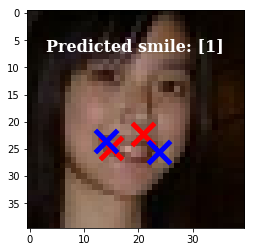

In [96]:
# Evaluate a single prediction
for label,row, predict_smile, predict_left_mouth, predict_right_mouth in zip(test_data_y[2:4,:],test_data_x[2:4,:], result[0][2:4,:], result[1][2:4,:], result[2][2:4,:]):
#     gender = np.where(predict_gender>0.5, 1, 0)

    _smile = np.where(predict_smile>0.5, 1, 0)
    plt.imshow(row / 255)
    plt.scatter(predict_left_mouth[0] * 40, predict_left_mouth[1] * 40, 500, marker='x', color='red', linewidth=5)
    plt.scatter(predict_right_mouth[0] * 40, predict_right_mouth[1] * 40, 500, marker='x', color='red', linewidth=5)
    plt.scatter(label[3] * 40, label[8] * 40, 500, marker='x', color='blue', linewidth=5)
    plt.scatter(label[4] * 40, label[9] * 40, 500, marker='x', color='blue', linewidth=5)
#     predictions = np.argmax(predict_pose)
    font = {'family': 'serif',
    'color':  'white',
    'weight': 'bold',
    'size': 16,
    }
#     plt.text(3, 3, 'Predicted pose: {}'.format(predictions),fontdict= font )
    plt.text(3, 7, 'Predicted smile: {} '.format(_smile),fontdict= font )
#     plt.text(3, 11, 'Predicted gender: {}'.format(gender),fontdict= font )
    break

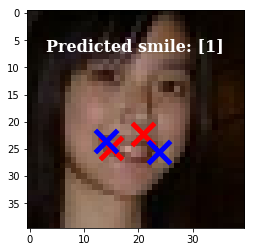

In [97]:
# Evaluate a single prediction
for label,row, predict_smile, predict_left_mouth, predict_right_mouth in zip(test_data_y[2:4,:],test_data_x[2:4,:], result[0][2:4,:], result[1][2:4,:], result[2][2:4,:]):
#     gender = np.where(predict_gender>0.5, 1, 0)

    _smile = np.where(predict_smile>0.5, 1, 0)
    plt.imshow(row / 255)
    plt.scatter(predict_left_mouth[0] * 40, predict_left_mouth[1] * 40, 500, marker='x', color='red', linewidth=5)
    plt.scatter(predict_right_mouth[0] * 40, predict_right_mouth[1] * 40, 500, marker='x', color='red', linewidth=5)
    plt.scatter(label[3] * 40, label[8] * 40, 500, marker='x', color='blue', linewidth=5)
    plt.scatter(label[4] * 40, label[9] * 40, 500, marker='x', color='blue', linewidth=5)
#     predictions = np.argmax(predict_pose)
    font = {'family': 'serif',
    'color':  'white',
    'weight': 'bold',
    'size': 16,
    }
#     plt.text(3, 3, 'Predicted pose: {}'.format(predictions),fontdict= font )
    plt.text(3, 7, 'Predicted smile: {} '.format(_smile),fontdict= font )
#     plt.text(3, 11, 'Predicted gender: {}'.format(gender),fontdict= font )
    break